# Initial prediction

In [1]:
import torch

In [2]:
import tensorflow
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.uint8)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.uint8)

2025-01-18 17:49:10.752865: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-18 17:49:10.762985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737202750.774919   61482 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737202750.778451   61482 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 17:49:10.790874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
x_train[0].size()

torch.Size([28, 28])

In [5]:
y_train.dtype

torch.uint8

In [3]:
trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=20, shuffle=True)
validloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=20, shuffle=True)

In [7]:
for i, j in enumerate(trainloader):
  print(i)
  print(j[0][0].size())
  break

0
torch.Size([28, 28])


In [41]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(784, 100),
    nn.Sigmoid(),
    nn.Linear(100, 100),
    nn.Sigmoid(),
    nn.Linear(100, 100),
    nn.Sigmoid(),
    nn.Linear(100, 10)
).to("cuda")

In [42]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=0.0005)

In [43]:
from tqdm import tqdm


previous_lr = optimizer.param_groups[0]["lr"]

for i in range(100):
    t = 0
    model.train()
    train_progress = tqdm(
        enumerate(trainloader), desc=f"Epoch {i} - Training", total=len(trainloader)
    )
    for j, k in train_progress:
        image, label = k
        image, label = image.to("cuda"), label.to("cuda")
        optimizer.zero_grad()
        output = model(image.view(-1, 784))
        l = loss(output, label)
        l.backward()
        optimizer.step()
        t += l.item()
        train_progress.set_postfix(loss=t / (j + 1))
    t /= len(trainloader)

    current_lr = optimizer.param_groups[0]["lr"]
    if current_lr != previous_lr:
        print(f"Learning Rate changed to {current_lr}")
        previous_lr = current_lr

    t = 0
    model.eval()
    val_progress = tqdm(
        enumerate(validloader), desc=f"Epoch {i} - Validation", total=len(validloader)
    )
    for j, k in val_progress:
        image, label = k
        image, label = image.to("cuda"), label.to("cuda")
        output = model(image.view(-1, 784))
        l = loss(output, label)
        t += l.item()
        val_progress.set_postfix(loss=t / (j + 1))
    t /= len(validloader)
    lr_scheduler.step(t)

Epoch 24 - Training: 100%|██████████| 3000/3000 [00:11<00:00, 266.38it/s, loss=0.231]


Learning Rate changed to 0.0015


Epoch 57 - Training: 100%|██████████| 3000/3000 [00:08<00:00, 356.69it/s, loss=0.147]


Learning Rate changed to 0.00075


Epoch 65 - Training: 100%|██████████| 3000/3000 [00:08<00:00, 370.92it/s, loss=0.118]


Learning Rate changed to 0.0005


Epoch 99 - Validation: 100%|██████████| 500/500 [00:00<00:00, 781.60it/s, loss=0.17] 


In [44]:
t = 0
for j, k in zip(x_test, y_test):
    image = j.to("cuda")
    with torch.no_grad():
        output = model(image.view(-1, 784))
    output = torch.nn.Softmax(dim=1)(output)
    output = torch.argmax(output).to("cpu")
    if output == k:
        t += 1


print(t / len(y_test))

0.9521


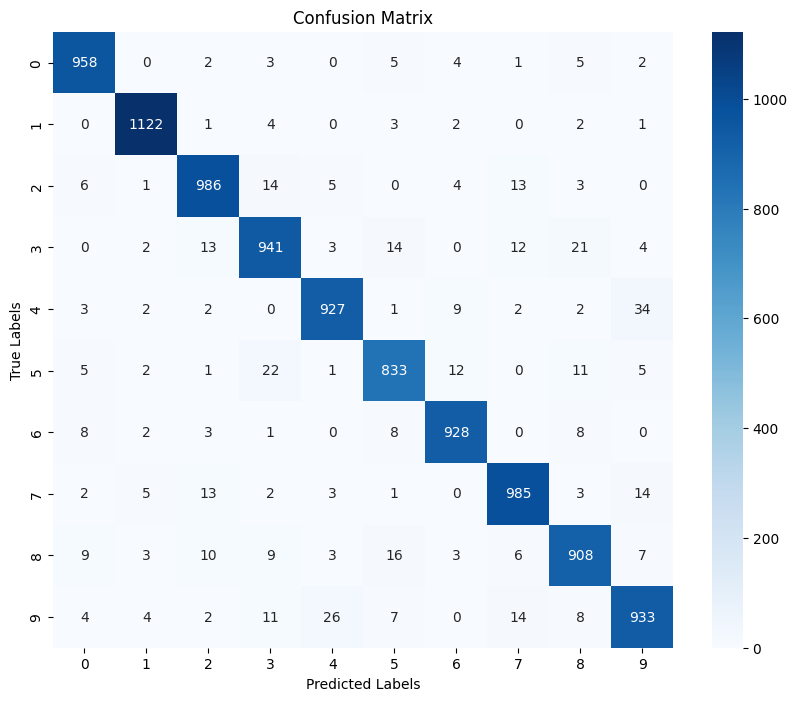

In [45]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

num_classes = 10
all_preds = []
all_labels = []

for images, labels in validloader:
    images, labels = images.to("cuda"), labels.to("cuda")

    with torch.no_grad():
        outputs = model(images.view(-1, 784))
        outputs = torch.nn.Softmax(dim=1)(outputs)
        preds = torch.argmax(outputs, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes),
            yticklabels=np.arange(num_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
outputs = []
for j, k in zip(x_test, y_test):
    image = j.to("cuda")
    with torch.no_grad():
        output = model(image.view(-1, 784))
    output = torch.nn.Softmax(dim=1)(output)
    output = torch.argmax(output).to("cpu")
    outputs.append(int(output))

In [52]:
with open("test_submission.csv", "w") as f:
    f.write("id,label\n")
    for i, j in enumerate(outputs):
        f.write(f"{i},{j}\n")

# 1, 2, 3 layers and  50, 100, 200 neurons

In [56]:
def model_maker(layers, neurons):
    model_layers = []
    for i in range(layers):
        if i == 0:
            model_layers.append(nn.Linear(784, neurons))
        else:
          model_layers.append(nn.Linear(neurons, neurons))
        model_layers.append(nn.Sigmoid())
    model_layers.append(nn.Linear(neurons, 10))
    model = nn.Sequential(*model_layers)
    return model

In [8]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
def train_loop(model, optimizer, loss, run_name):
    writer = SummaryWriter(log_dir=f"runs/{run_name}")
    for i in range(50):
        t = 0
        model.train()
        train_progress = tqdm(
            enumerate(trainloader), desc=f"Epoch {i} - Training", total=len(trainloader)
        )
        for j, k in train_progress:
            image, label = k
            image, label = image.to("cuda"), label.to("cuda")
            optimizer.zero_grad()
            output = model(image.view(-1, 784))
            l = loss(output, label)
            l.backward()
            optimizer.step()
            t += l.item()
            train_progress.set_postfix(loss=t / (j + 1))
        t /= len(trainloader)
        writer.add_scalar("Loss/Train", t, i)
        t = 0
        model.eval()
        val_progress = tqdm(
            enumerate(validloader), desc=f"Epoch {i} - Validation", total=len(validloader)
        )
        for j, k in val_progress:
            image, label = k
            image, label = image.to("cuda"), label.to("cuda")
            output = model(image.view(-1, 784))
            l = loss(output, label)
            t += l.item()
            val_progress.set_postfix(loss=t / (j + 1))
        t /= len(validloader)
        writer.add_scalar("Loss/Validation", t, i)
        writer.flush()
    writer.close()

In [66]:
for i in [1, 2, 3]:
    for j in [50, 100, 200]:
        print(f"Training model with {i} layers and {j} neurons")
        model = model_maker(i, j).to("cuda")
        loss = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
        train_loop(model, optimizer, loss, f"layers_{i}_neurons_{j}")

Training model with 1 layers and 50 neurons


Epoch 0 - Training:   0%|          | 0/3000 [00:00<?, ?it/s, loss=2.25]

Epoch 49 - Validation: 100%|██████████| 500/500 [00:00<00:00, 524.61it/s, loss=0.281]


Training model with 1 layers and 100 neurons


Epoch 49 - Validation: 100%|██████████| 500/500 [00:00<00:00, 707.10it/s, loss=0.256]


Training model with 1 layers and 200 neurons


Epoch 49 - Validation: 100%|██████████| 500/500 [00:00<00:00, 708.43it/s, loss=0.256]


Training model with 2 layers and 50 neurons


Epoch 49 - Validation: 100%|██████████| 500/500 [00:01<00:00, 485.66it/s, loss=0.259]


Training model with 2 layers and 100 neurons


Epoch 49 - Validation: 100%|██████████| 500/500 [00:00<00:00, 822.98it/s, loss=0.235]


Training model with 2 layers and 200 neurons


Epoch 49 - Validation: 100%|██████████| 500/500 [00:01<00:00, 418.74it/s, loss=0.187]


Training model with 3 layers and 50 neurons


Epoch 49 - Validation: 100%|██████████| 500/500 [00:01<00:00, 314.28it/s, loss=0.302]


Training model with 3 layers and 100 neurons


Epoch 49 - Validation: 100%|██████████| 500/500 [00:01<00:00, 384.71it/s, loss=0.249]


Training model with 3 layers and 200 neurons


Epoch 49 - Validation: 100%|██████████| 500/500 [00:00<00:00, 562.05it/s, loss=0.224]


# 4. Activation functions

In [11]:
def model_maker1():
    model = nn.Sequential(
        nn.Linear(784, 100),
        nn.Sigmoid(),
        nn.Linear(100, 100),
        nn.Sigmoid(),
        nn.Linear(100, 10),
    ).to("cuda")
    return model

In [12]:
names = ["adam", "nag", "momentum", "sgd"]
for i in names:
    model = model_maker1()
    if i == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    elif i == "nag":
        optimizer = torch.optim.SGD(
            model.parameters(), lr=0.001, nesterov=True, momentum=0.9, dampening=0
        )
    elif i == "momentum":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    train_loop(model, optimizer, nn.CrossEntropyLoss(), i)

Epoch 49 - Validation: 100%|██████████| 500/500 [00:01<00:00, 440.22it/s, loss=0.196]


# 5. sigmoid vs tanh

In [6]:
import torch.nn as nn
model0 = nn.Sequential(
    nn.Linear(784, 100),
    nn.Sigmoid(),
    nn.Linear(100, 100),
    nn.Sigmoid(),
    nn.Linear(100, 10),
).to("cuda")

model1 = nn.Sequential(
    nn.Linear(784, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 10),
).to("cuda")

In [10]:
names = ["Sigmoid", "Tanh"]
models = [model0, model1]
for name, model in zip(names, models):
    train_loop(model, torch.optim.Adam(model.parameters(), lr=0.003), torch.nn.CrossEntropyLoss(), name)

Epoch 49 - Validation: 100%|██████████| 500/500 [00:00<00:00, 630.93it/s, loss=0.36] 


# 6. Loss fn comparison


In [68]:
trainloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train, y_train), batch_size=20, shuffle=True
)
validloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test, y_test), batch_size=20, shuffle=True
)

In [71]:
losses = [torch.nn.CrossEntropyLoss(), torch.nn.MSELoss()]
for loss in losses:
    model = model_maker1()
    train_loop(
        model,
        torch.optim.Adam(model.parameters(), lr=0.003),
        loss,
        loss.__class__.__name__,
    )

Epoch 0 - Training:   0%|          | 0/3000 [00:00<?, ?it/s, loss=2.32]

Epoch 0 - Training:   0%|          | 0/3000 [00:00<?, ?it/s]/home/shusrith/projects/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0 - Training:   0%|          | 0/3000 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (10) must match the size of tensor b (20) at non-singleton dimension 1

## MSE

In [72]:
model = nn.Sequential(
    nn.Linear(784, 100),
    nn.Sigmoid(),
    nn.Linear(100, 100),
    nn.Sigmoid(),
    nn.Linear(100, 10),
    nn.Softmax(dim=1)
).to("cuda")

loss = nn.MSELoss()

In [81]:
import torch.nn.functional as F
def one_hot_encode(labels, num_classes=10):
    """Convert integer labels to one-hot encoded vectors."""
    labels = labels.type(torch.long)
    return F.one_hot(labels, num_classes=num_classes).float()

In [106]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
model = model_maker1()

writer = SummaryWriter(log_dir=f"runs/MSELoss")
for i in range(50):
    train_loss = 0
    model.train()
    train_progress = tqdm(
        enumerate(trainloader), desc=f"Epoch {i} - Training", total=len(trainloader)
    )
    for j, (images, labels) in train_progress:
        images, labels = images.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(images.view(-1, 784))
        labels_one_hot = one_hot_encode(labels, num_classes=10)
        l = loss(outputs, labels_one_hot) 
        l.backward()
        optimizer.step()
        train_loss += l.item()
        train_progress.set_postfix(loss=train_loss / (j + 1))
    train_loss /= len(trainloader)
    writer.add_scalar("Loss/Train", train_loss, i)
    val_loss = 0
    model.eval()
    val_progress = tqdm(
        enumerate(validloader),
        desc=f"Epoch {i} - Validation",
        total=len(validloader),
    )
    with torch.no_grad():
        for j, (images, labels) in val_progress:
            images, labels = images.to("cuda"), labels.to("cuda")
            labels_one_hot = one_hot_encode(
                labels, num_classes=10
            )  # One-hot encode labels
            outputs = model(images.view(-1, 784))
            l = loss(outputs, labels_one_hot)  # Compute MSE loss
            val_loss += l.item()
            val_progress.set_postfix(loss=val_loss / (j + 1))
    val_loss /= len(validloader)
    writer.add_scalar("Loss/Validation", val_loss, i)

    writer.flush()
writer.close()

Epoch 49 - Validation: 100%|██████████| 500/500 [00:00<00:00, 608.67it/s, loss=0.17] 


# 7. Batch sizes

In [13]:
def model_maker1():
    model = nn.Sequential(
        nn.Linear(784, 100),
        nn.Sigmoid(),
        nn.Linear(100, 100),
        nn.Sigmoid(),
        nn.Linear(100, 10),
    ).to("cuda")
    return model

In [14]:
sizes = [1000, 100, 20, 10]
for i in sizes:
    trainloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=i, shuffle=True
    )
    validloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), batch_size=i, shuffle=True
    )
    model = model_maker1()
    train_loop(
        model,
        torch.optim.Adam(model.parameters(), lr=0.003),
        torch.nn.CrossEntropyLoss(),
        f"{i}",
    )

Epoch 49 - Validation: 100%|██████████| 1000/1000 [00:02<00:00, 392.71it/s, loss=0.239]
